### XGBoost
XGBoost is an implementation of gradient boosted decision trees designed for speed and performance.
Boosting is an ensemble technique where new models are added to correct the errors made by existing models. Models are added sequentially until no further improvements can be made. A popular example is the AdaBoost algorithm that weights data points that are hard to predict.

Gradient boosting is an approach where new models are created that predict the residuals or errors of prior models and then added together to make the final prediction. It is called gradient boosting because it uses a gradient descent algorithm to minimize the loss when adding new models.
We will use toy data set: https://www.kaggle.com/mohammeddagga/eda-toy-dataset

In [1]:
import xgboost as xgb
import pandas as pd
import numpy as np
from sklearn.utils import shuffle
from sklearn.metrics import confusion_matrix, mean_squared_error, classification_report
from sklearn.model_selection import KFold, train_test_split, GridSearchCV
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.preprocessing import OneHotEncoder

In [2]:
df = pd.read_csv('toy_dataset.csv')
df.head()

,Number,City,Gender,Age,Income,Illness
0,1,Dallas,Male,41,40367.0,No
1,2,Dallas,Male,54,45084.0,No
2,3,Dallas,Male,42,52483.0,No
3,4,Dallas,Male,40,40941.0,No
4,5,Dallas,Male,46,50289.0,No


In [3]:
def encode_and_bind(original_dataframe, feature_to_encode):
    dummies = pd.get_dummies(original_dataframe[[feature_to_encode]])
    res = pd.concat([original_dataframe, dummies], axis=1)
    return(res)

df = encode_and_bind(df, 'City')

In [7]:
illness = {'No':0, 'Yes':1}
gender = {'Male': 1, 'Female':2}

df['Illness'] = df['Illness'].map(illness)
df['Gender'] = df['Gender'].map(gender)

df = df.drop(['Number', 'City'], axis =1)


In [8]:
df = shuffle(df) # we have to shuffle data set becease the ill people are at the end of the dataset

In [9]:
X = np.asarray(df.drop('Illness', axis =1))

In [10]:
y = np.asarray(df['Illness'])

In [11]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=101)

In [20]:
# we run the xgb model with early stoping and we make a small grid search

xgb_model = xgb.XGBClassifier(n_jobs=1)
clf = GridSearchCV(xgb_model,
                   {'max_depth': [2, 4, 6],
                    'n_estimators': [50, 100, 200]}, verbose=1, n_jobs=1)
clf.fit(X_train, y_train)
print('best score: ',clf.best_score_)
print('best parameters:', clf.best_params_)

Fitting 5 folds for each of 9 candidates, totalling 45 fits
best score:  0.9195047619047619
best parameters: {'max_depth': 2, 'n_estimators': 50}


In [25]:
final_xgb_model =  xgb.XGBClassifier(n_estimators=50, max_depth=2, learning_rate=0.1).fit(X_train, y_train, early_stopping_rounds=10, eval_metric="auc",
        eval_set=[(X_test, y_test)])
predictions = final_xgb_model.predict(X_test)
print(confusion_matrix(y_test, predictions))

[0]	validation_0-auc:0.50000
Will train until validation_0-auc hasn't improved in 10 rounds.
[1]	validation_0-auc:0.50000
[2]	validation_0-auc:0.50000
[3]	validation_0-auc:0.50000
[4]	validation_0-auc:0.50000
[5]	validation_0-auc:0.50000
[6]	validation_0-auc:0.49760
[7]	validation_0-auc:0.49760
[8]	validation_0-auc:0.49760
[9]	validation_0-auc:0.49621
[10]	validation_0-auc:0.49639
Stopping. Best iteration:
[0]	validation_0-auc:0.50000

[[41313     0]
 [ 3687     0]]


In [26]:
mean_squared_error(y_test, predictions)

0.08193333333333333

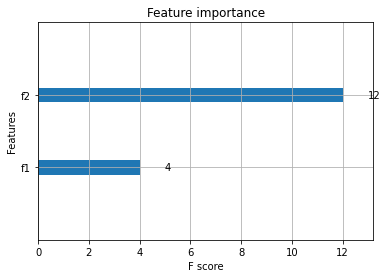

In [27]:
xgb.plot_importance(final_xgb_model); # age and income are the best predictor of illness

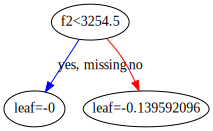

In [28]:
xgb.to_graphviz(final_xgb_model, num_trees=2)

In [29]:
import warnings
warnings.filterwarnings("ignore")
print(classification_report(y_test, predictions, target_names=['Healthy', 'Ill']))

              precision    recall  f1-score   support

     Healthy       0.92      1.00      0.96     41313
         Ill       0.00      0.00      0.00      3687

    accuracy                           0.92     45000
   macro avg       0.46      0.50      0.48     45000
weighted avg       0.84      0.92      0.88     45000



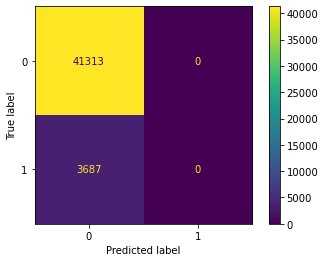

In [30]:
np.set_printoptions(precision=2)

cm = confusion_matrix(y_test, predictions, labels=final_xgb_model.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                           display_labels=final_xgb_model.classes_)
disp.plot(); # this model is so poor probably becease there are no valid predictors for predicting illness, 
# illness in nomraly distributed through age and income

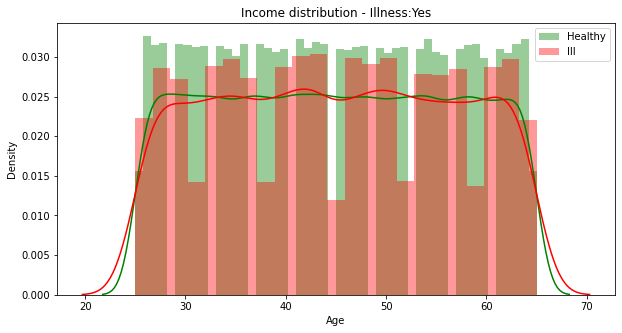

In [31]:
import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize=(10,5))
sns.distplot(df[df["Illness"] == 0]["Age"], color="g", label = 'Healthy')
sns.distplot(df[df["Illness"] == 1]["Age"], color="r", label = 'Ill')
plt.legend()
plt.title("Income distribution - Illness:Yes")
plt.show()

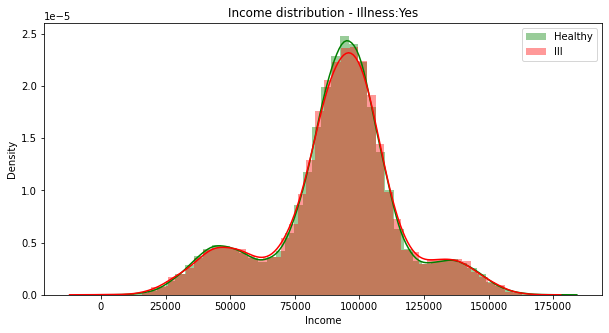

In [33]:
import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize=(10,5))
sns.distplot(df[df["Illness"] == 0]["Income"], color="g", label = 'Healthy')
sns.distplot(df[df["Illness"] == 1]["Income"], color="r", label = 'Ill')
plt.legend()
plt.title("Income distribution - Illness:Yes")
plt.show() # there are no predictors in this dataset that could differentiate Healthy and Ill